In [1]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import STL
from arch.unitroot import PhillipsPerron
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm

In [3]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Mandal_boundaries_pre')
mandal_boundaries = gpd.read_file('mandal_boundaries.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2020-01-1')]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\other')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner")

#Create the right time format: we count per month per year
fires_per_mandal['day'] = 1 #pd.Series(pd.to_numeric(fires_per_mandal['day'], errors='coerce'), dtype='int64')
fires_per_mandal['year'] = pd.Series(pd.to_numeric(fires_per_mandal['year'], errors='coerce'), dtype='int64')
fires_per_mandal['month'] = pd.Series(pd.to_numeric(fires_per_mandal['month'], errors='coerce'), dtype='int64')
fires_per_mandal['ModifiedDateTime'] = pd.to_datetime(fires_per_mandal[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on mandal and time
fires_per_mandal_count = fires_per_mandal.sort_values(by=['Dist_Name', 'Mandal_Nam', 'ModifiedDateTime'])

#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_mandal_count = fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()

fires_per_mandal_count['Amount of Fires'] = fires_per_mandal_count[0] #/ round(fires_per_mandal_count['Crops']/1000000)

#Delete column
del fires_per_mandal_count[0]

#For standardizing the amount of fires regarding crop area in a mandal
#fires_per_mandal_count = fires_per_mandal_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'Crops']], how='left', on=['Dist_Name', 'Mandal_Nam'])
#fires_per_mandal_count['Crops'] = (fires_per_mandal_count['Crops']/1000000)
#fires_per_mandal_count['Standardized'] = (fires_per_mandal_count['Amount of Fires'] /fires_per_mandal_count['Crops'])
#fires_per_mandal_count['Standardized'].fillna(0)
#fires_per_mandal_count['Standardized'] = fires_per_mandal_count['Standardized'].astype(int)

<ipython-input-4-829794e32bdc>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner")


In [5]:
#Select the column we are interested in standardized or non-standardized
fires_per_mandal_count['Fires'] = fires_per_mandal_count['Amount of Fires'] 

In [6]:
#fires_per_mandal_count[fires_per_mandal_count['Fires']!=0]
fires_per_mandal_count.sort_values('Fires', ascending = False)

,Dist_Name,Mandal_Nam,ModifiedDateTime,Amount of Fires,Fires
17434,Nizamabad,Kotagiri,2017-11-01,13,13
1873,Bhadradri Kothagudem,Yellandu,2016-02-01,13,13
17848,Nizamabad,Nandipet,2017-05-01,12,12
12791,Mulugu,Venkatapur,2015-12-01,11,11
8977,Mahabubabad,Gangaram,2018-02-01,11,11
...,...,...,...,...,...
10150,Mahabubnagar,Nawabpet,2015-11-01,0,0
10148,Mahabubnagar,Nawabpet,2015-09-01,0,0
10147,Mahabubnagar,Nawabpet,2015-08-01,0,0
10146,Mahabubnagar,Nawabpet,2015-07-01,0,0


In [7]:
total_fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
total_fires_per_mandal = total_fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam'])['fireID'].count().reset_index()

<ipython-input-7-a4c1d2c7f9c6>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  total_fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')


In [70]:
fires_per_mandal_count['Month'] = (fires_per_mandal_count['ModifiedDateTime']).dt.month
fires_per_mandal_count['Year'] = (fires_per_mandal_count['ModifiedDateTime']).dt.year

In [71]:
def Trend_Mandals(df, district_name, mandal_name): 
    district = df[df['Dist_Name'] == district_name] 
    mandal = district[district['Mandal_Nam'] == mandal_name]
    mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
    mandal = mandal.sort_values(by=['ModifiedDateTime'])
    mandal.index = mandal['ModifiedDateTime']

    if not mandal.empty:

        X = mandal['Fires']
        #result = adfuller(X)
        #ADF_p_value = result[1]

        #kpsstest = kpss(X, regression='c', nlags="auto")
        #kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
        #kpss_p_value = kpss_output[1]

        #php_ct = PhillipsPerron(X)
        #pp_p_value = float(php_ct.summary().as_text().split()[8])

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(mandal['Fires'], seasonal=7)
        res = stl.fit()
        #res.plot()

        #Moving Averages
        result_year = seasonal_decompose(mandal['Fires'], model='additive')

        df_trend = res.trend.to_frame().reset_index().dropna()
        df_trend = df_trend.reset_index()
        df_trend['ModifiedDateTime_num'] = df_trend['index']
        
        #df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)

        y_pred_trend = reg.predict(X)

        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)

        regression_score = reg.score(X, y)
        line_slope = slope[0]

    else:
        line_slope = 'Unknown'
        regression_score = 'Unknown' 
        ADF_p_value = 'Unknown'
        kpss_p_value = 'Unknown' 
        pp_p_value = 'Unknown'

    return(line_slope, regression_score)

In [75]:
def Trend_Mandals_printed(df, district_name, mandal_name):   
    district = df[df['Dist_Name'] == district_name] 
    mandal = district[district['Mandal_Nam'] == mandal_name]
    mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
    mandal = mandal.sort_values(by=['ModifiedDateTime'])
    mandal.index = mandal['ModifiedDateTime'] 
    
    if not mandal.empty:
        #plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
        #autocorrelation_plot(mandal['Fires'].tolist())
        #plt.show()
        
        X = mandal['Fires']
        
        
        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(mandal['Fires'], seasonal = 5, period = 12)
        res = stl.fit()
        res.plot()
        plt.figure(figsize=(1,6))
        plt.show()

        #Moving Averages
        #result_year = seasonal_decompose(mandal['Fires'], model='additive')
        #result_year.plot()
        
        #plt.show()

        df_trend = res.trend.to_frame().reset_index().dropna()
        df_trend = df_trend.reset_index()
        df_trend['ModifiedDateTime_num'] = df_trend['index']
        #df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        reg.score(X, y)

        y_pred_trend = reg.predict(X)

        plt.figure(figsize=(12,6))
        plt.scatter(df_trend['ModifiedDateTime'], df_trend['trend'], color="black")
        plt.plot(df_trend['ModifiedDateTime'], y_pred_trend, color="blue", linewidth=3)
        plt.xlabel('Date')
        plt.ylabel('Trend')
        plt.title('Linear Regression Fit on Trend Mandal: ' + mandal_name)
        plt.show()

        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        print(slope, intercept)

        return(slope[0], df_trend)

<ipython-input-75-07278492e083>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])


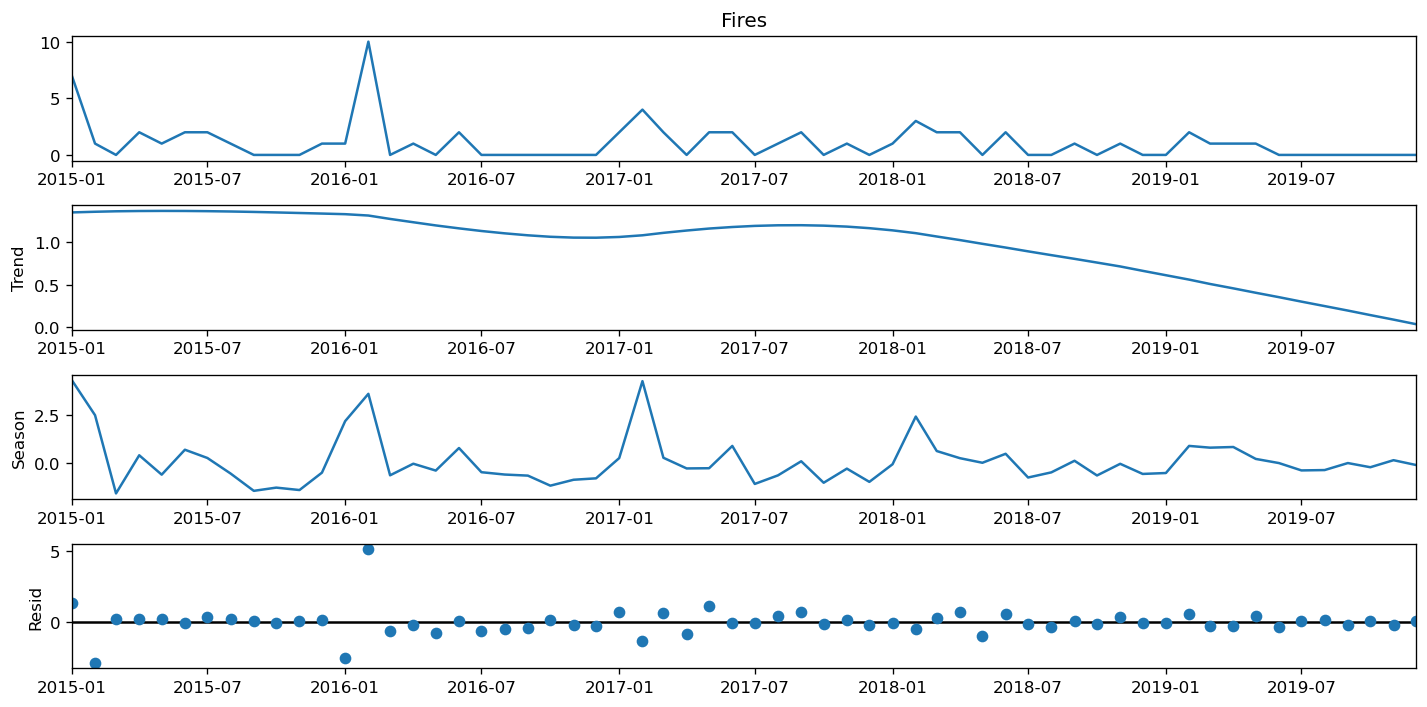

<Figure size 120x720 with 0 Axes>

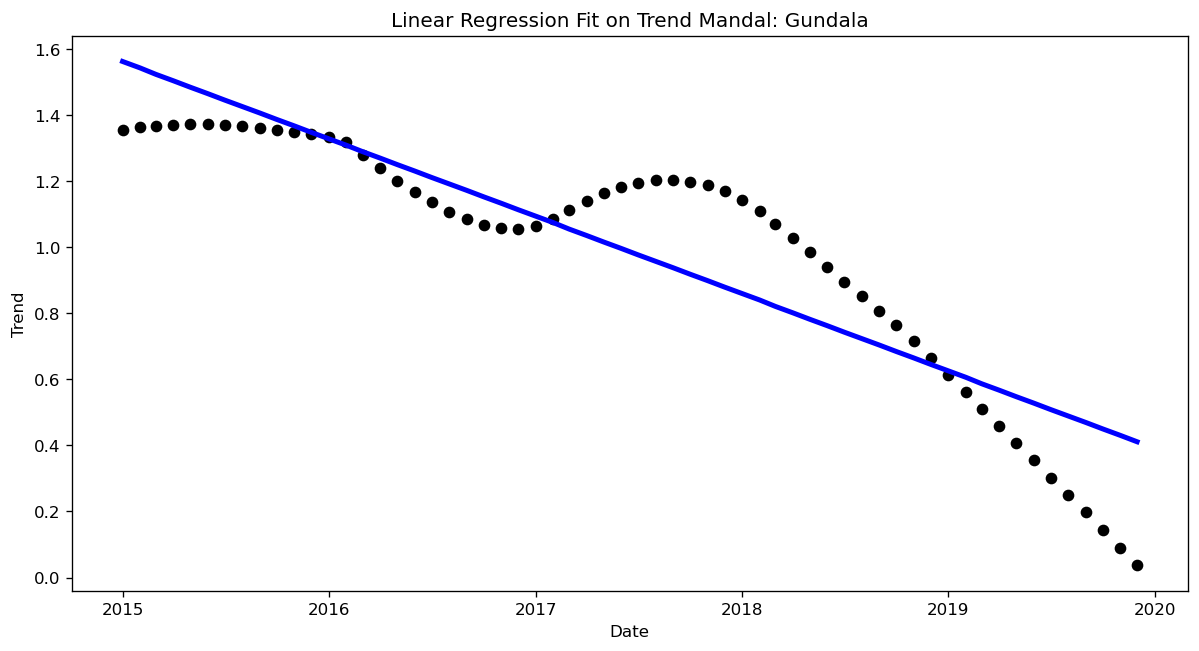

[-0.01950631] [1.56181445]


In [76]:
slope, df_trend = Trend_Mandals_printed(fires_per_mandal_count, 'Bhadradri Kothagudem', 'Gundala')

In [77]:
df_trend

,index,ModifiedDateTime,trend,ModifiedDateTime_num
0,0,2015-01-01,1.354302,0
1,1,2015-02-01,1.362117,1
2,2,2015-03-01,1.367619,2
3,3,2015-04-01,1.370865,3
4,4,2015-05-01,1.372062,4
5,5,2015-06-01,1.371391,5
6,6,2015-07-01,1.369025,6
7,7,2015-08-01,1.365192,7
8,8,2015-09-01,1.360127,8
9,9,2015-10-01,1.354106,9


In [9]:
#DPPD Scores: The negativer the number, we observe a higher decrease in fires over the years
#The completely white mandals are the mandals in which no agricultural fires are observed
DPPD_df= pd.DataFrame(columns=['Dist_Name', 'Mandal_Nam', 'Slope Score'])
dist = []
mandals = []
scores = []
accuracies = []
#adf_scores = []
#kpss_scores = []
#pp_scores = []
for i in range(0, len(mandal_boundaries['Dist_Name'])):
    dist.append(mandal_boundaries['Dist_Name'].iloc[i])
    mandals.append(mandal_boundaries['Mandal_Nam'].iloc[i])
    score, accuracy = Trend_Mandals(fires_per_mandal_count, mandal_boundaries['Dist_Name'].iloc[i], mandal_boundaries['Mandal_Nam'].iloc[i])
    scores.append(score)
    accuracies.append(accuracy)
    #adf_scores.append(adf)
    #kpss_scores.append(kpss_)
    #pp_scores.append(pp)

DPPD_df = pd.DataFrame({'Dist_Name': dist, 'Mandal_Nam': mandals, 'Slope Score': scores, 'Regression Score': accuracies}) # 'Augmented Dickey Fuller Test': adf_scores, 'Kpss Test': kpss_scores, 'PhillipsPerron': pp_scores})

<ipython-input-7-7b00ffe80a47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
<ipython-input-7-7b00ffe80a47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
<ipython-input-7-7b00ffe80a47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [10]:
DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']
DPPD_df = DPPD_df.sort_values('Slope Score')
DPPD_df = DPPD_df.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry']], how='left', on=['Dist_Name', 'Mandal_Nam'])
DPPD_df = DPPD_df.merge(total_fires_per_mandal[['Dist_Name', 'Mandal_Nam', 'fireID']], how='left', on=['Dist_Name', 'Mandal_Nam'])
DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')



c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


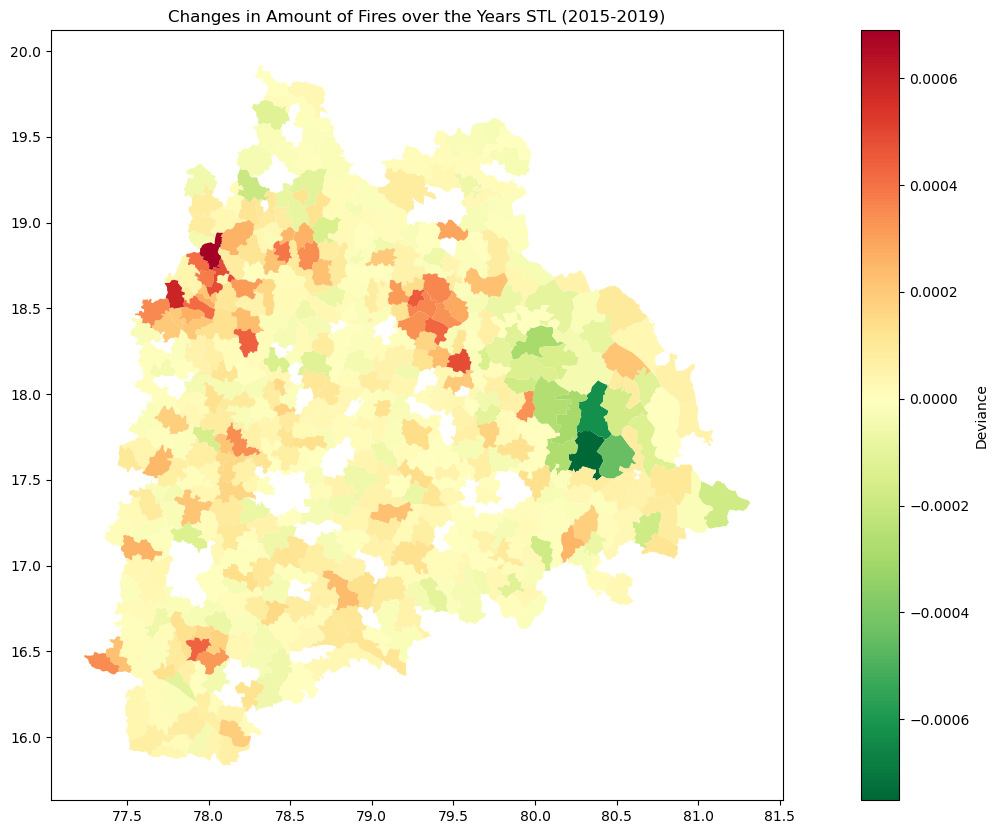

In [12]:
vmin, vmax, vcenter = DPPD_df['Slope Score'].min(), DPPD_df['Slope Score'].max(), 0
norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) #-0.00150 #0.00060
# create a normalized colorbar
cmap = 'RdYlGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
DPPD_df.plot(column = 'Slope Score', 
                      legend = True, 
                      figsize = [20,10],\
                      legend_kwds = {'label': 'Deviance'}, 
                      cmap = 'RdYlGn_r',
                      norm = norm)
plt.title('Changes in Amount of Fires over the Years STL (2015-2019)')
#plt.savefig('Changes in Amount of Fires over the Years STL (2015-2019).png')
plt.show()


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


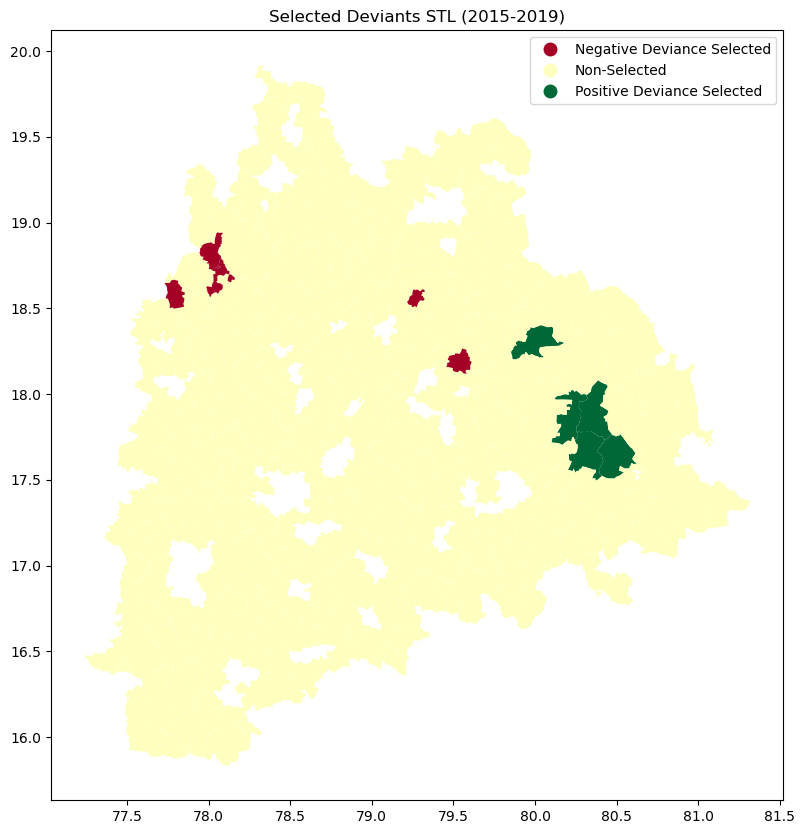

In [13]:
DPPD_df['Deviants'] = 'Non-Selected'
DPPD_df = DPPD_df.dropna()
DPPD_df['Deviants'].iloc[:5] = 'Positive Deviance Selected'
DPPD_df['Deviants'].iloc[-5:] = 'Negative Deviance Selected'

DPPD_df.plot(column = 'Deviants', 
                      legend = True, 
                      figsize = [20,10],
                      cmap = 'RdYlGn')
plt.title('Selected Deviants STL (2015-2019)')
#plt.savefig('Selected Deviants STL (2015-2019).png')
plt.show()


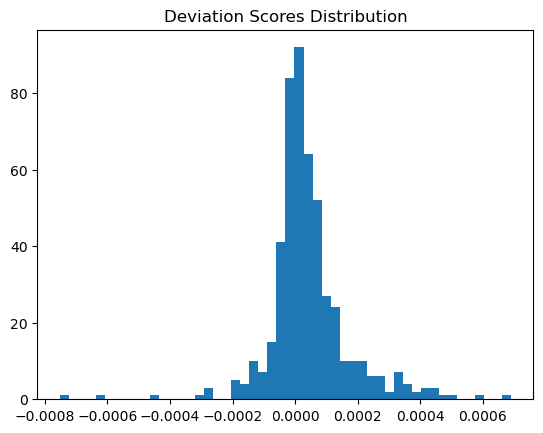

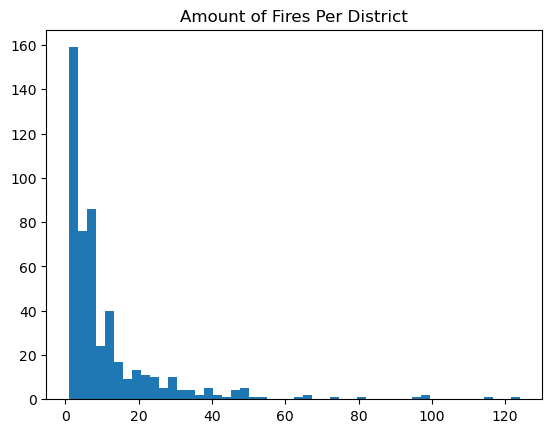

In [14]:
plt.hist(DPPD_df['Slope Score'], bins = 50)
plt.title('Deviation Scores Distribution')
plt.show()

plt.hist(DPPD_df['fireID'], bins = 50)
plt.title('Amount of Fires Per District')
plt.show()

In [15]:
DPPD_df[DPPD_df['Deviants'] == 'Positive Deviance Selected']

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,geometry,fireID,Deviants
0,Bhadradri Kothagudem,Yellandu,-0.000752,0.303074,"POLYGON ((80.34248 17.78495, 80.39431 17.74970...",124,Positive Deviance Selected
1,Bhadradri Kothagudem,Gundala,-0.000628,0.848159,"POLYGON ((80.42952 18.05816, 80.43134 18.05733...",95,Positive Deviance Selected
2,Bhadradri Kothagudem,Tekulapalle,-0.000441,0.717742,"POLYGON ((80.53010 17.75629, 80.53204 17.75473...",50,Positive Deviance Selected
3,Mahabubabad,Gangaram,-0.000297,0.140721,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",97,Positive Deviance Selected
4,Mulugu,Venkatapur,-0.000290,0.167323,"POLYGON ((80.03853 18.40128, 80.04067 18.40109...",73,Positive Deviance Selected


In [16]:
DPPD_df[DPPD_df['Deviants'] == 'Negative Deviance Selected']

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,geometry,fireID,Deviants
494,Peddapalli,Eligaid,0.000455,0.536225,"POLYGON ((79.31233 18.61133, 79.31250 18.61130...",21,Negative Deviance Selected
495,Nizamabad,Nizamabad Rural,0.000486,0.325725,"MULTIPOLYGON (((78.13497 18.69678, 78.13504 18...",49,Negative Deviance Selected
496,Warangal_Urban,Kamalapur,0.000488,0.41405,"POLYGON ((79.56420 18.26239, 79.56486 18.26234...",24,Negative Deviance Selected
497,Nizamabad,Kotagiri,0.000585,0.184785,"POLYGON ((77.83827 18.62068, 77.83827 18.61972...",98,Negative Deviance Selected
498,Nizamabad,Navipet,0.000690,0.80042,"POLYGON ((78.08734 18.94072, 78.08733 18.94070...",67,Negative Deviance Selected


In [17]:
DPPD_df['Absolute Slope Score']= abs(DPPD_df['Slope Score'])
DPPD_df_neutrals = DPPD_df[DPPD_df['Absolute Slope Score']<0.00002]
DPPD_df_neutrals.sort_values(['fireID'], ascending = False).head()

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,geometry,fireID,Deviants,Absolute Slope Score
111,Bhadradri Kothagudem,Dammapeta,-0.000020,0.003262,"POLYGON ((81.01204 17.49259, 81.01205 17.49256...",31,Non-Selected,0.000020
160,Jayashankar Bhupalpally,Bhupalpally,-0.000005,0.00054,"POLYGON ((79.90614 18.51869, 79.90821 18.51769...",30,Non-Selected,0.000005
226,Nizamabad,Bheemgal,0.000015,0.004368,"POLYGON ((78.47735 18.75343, 78.47919 18.75219...",19,Non-Selected,0.000015
153,Khammam,Mudigonda,-0.000008,0.001303,"POLYGON ((80.16039 17.18372, 80.16069 17.18103...",19,Non-Selected,0.000008
233,Khammam,Thallada,0.000017,0.004149,"POLYGON ((80.44875 17.30464, 80.44929 17.30445...",19,Non-Selected,0.000017


<ipython-input-8-991244f316a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])


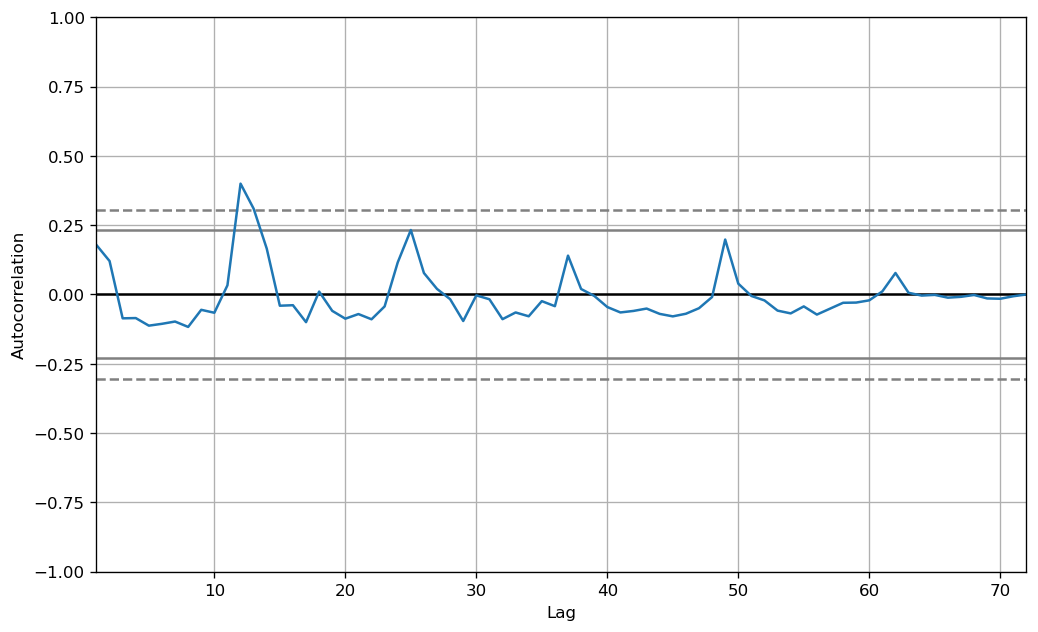

Results of ADF Test:
ADF Statistic: -7.178781
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


Results of KPSS Test:
Test Statistic           0.315853
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


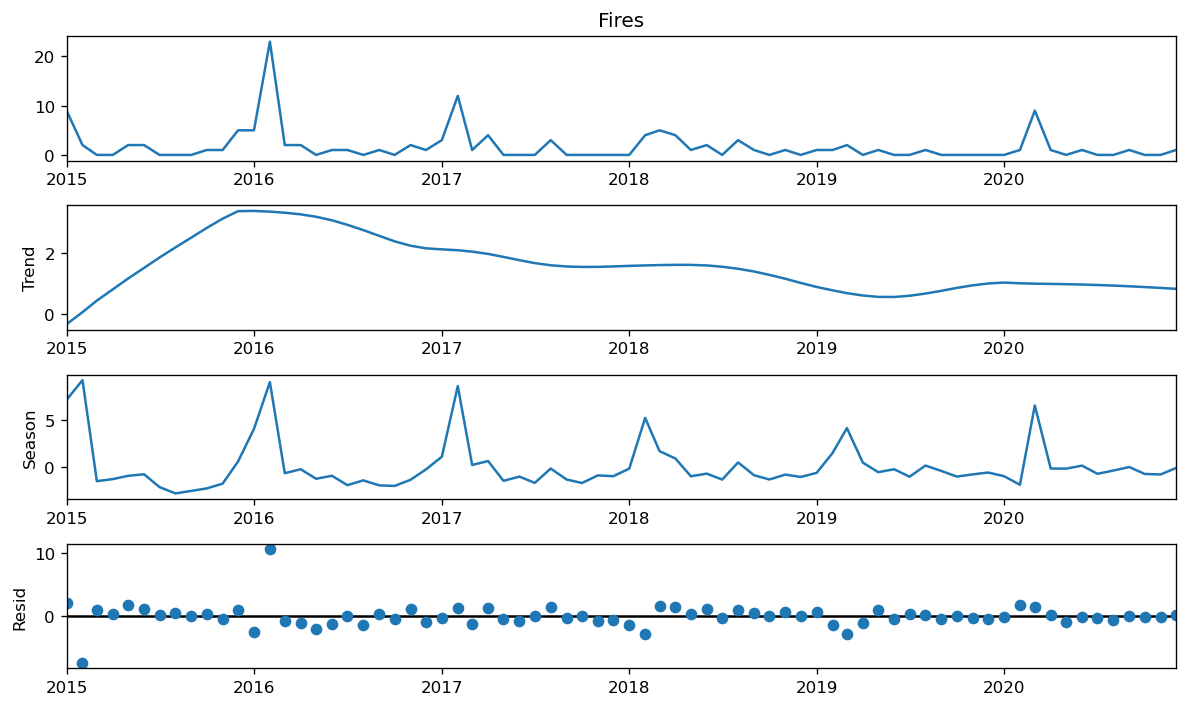

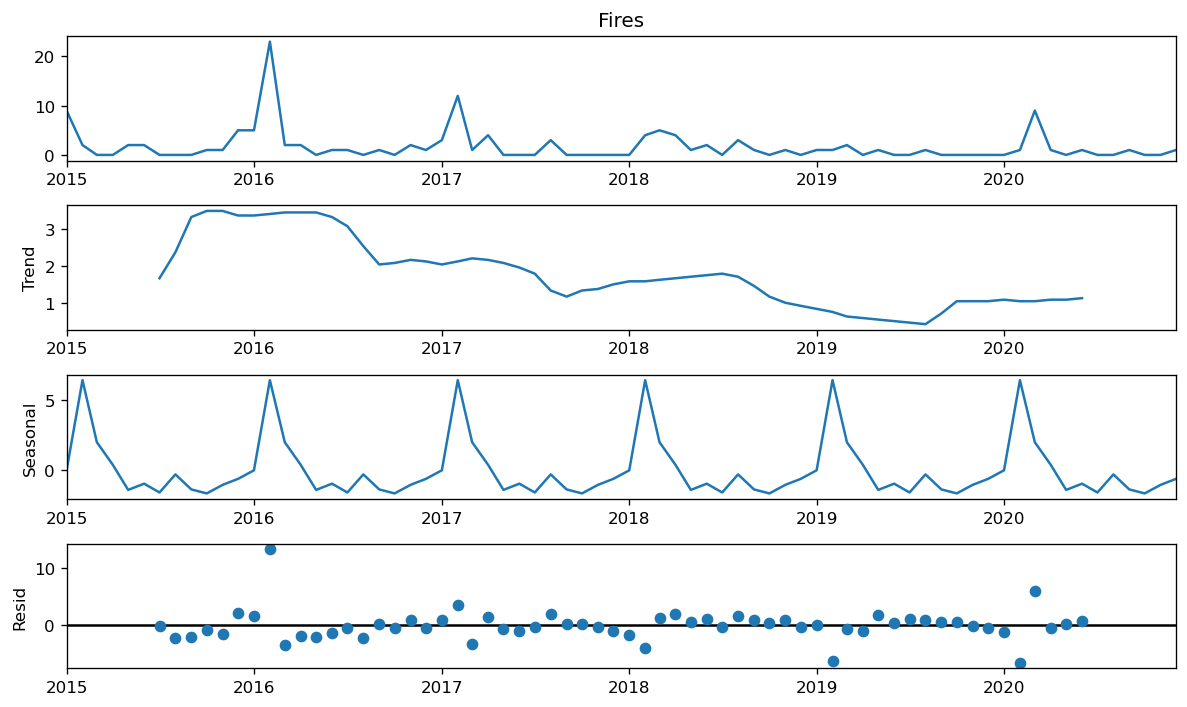

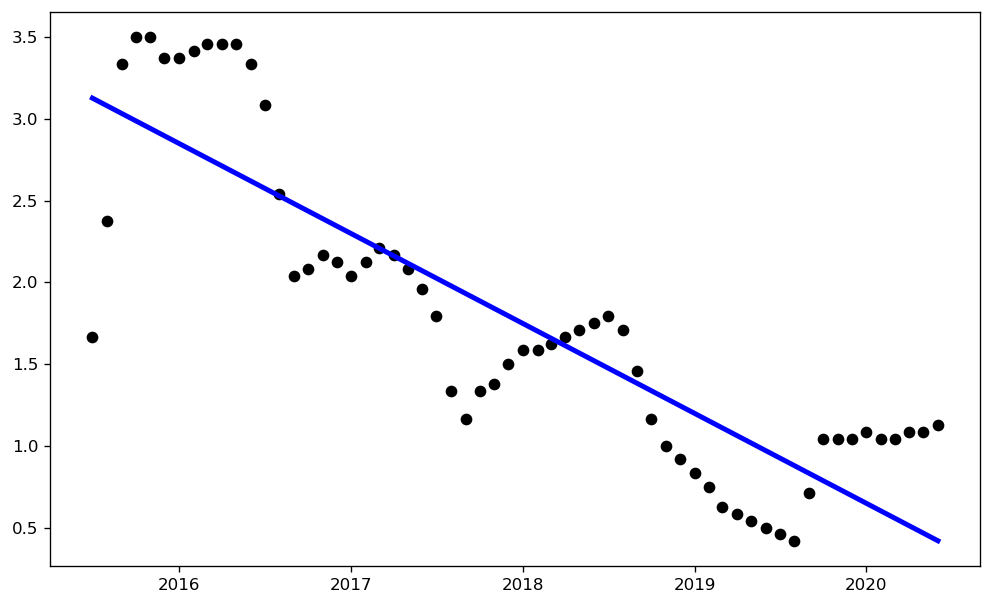

[-0.00150689] [1111.86488376]


-0.0015068880231399275

In [18]:
Trend_Mandals_printed(fires_per_mandal_count, 'Bhadradri Kothagudem', 'Yellandu')